# EO/GIS Skill Check
Please complete the following task sequence using Python and the libraries of your choice and return the executed Notebook to us.

1. Define an area of interest (AOI) of your choice (Polygon)
2. Download a Sentinel 2 stack for the aoi for the year 2023 with all scenes with less than 30% cloud cover
   (hint: https://stackstac.readthedocs.io/en/latest/basic.html)
3. Crop the S2 stack to the AOI
4. Plot the first time step of the S2 stack as NIR-RED-BLUE composite and the aoid vector data on top
5. Calculate the bare soil index (BSI) for each timestep
6. Create a binary mask of bare soil pixels for each timestep
7. Resample the soil mask stack to geographic coordinates (epsg:4326)
8. Aggregate bare soil percentage within the AOI  for each timestep and plot the resulting time series.




# Solution

First three questions done together for for personal ease of code writing

## 1.
Define an area of interest (AOI) of your choice (Polygon)


## & 2.
Download a Sentinel 2 stack for the aoi for the year 2023 with all scenes with less than 30% cloud cover (hint: https://stackstac.readthedocs.io/en/latest/basic.html)

## & 3.
Crop the S2 stack to the AOI

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon

coordinates = [
    (14.75, 50.9),
    (14.85, 50.9),
    (14.85, 50.8),
    (14.75, 50.8),
    (14.75, 50.9)
]

polygon = Polygon(coordinates)

# I would import the data by specifying 'crs='EPSG:4326' as an argument, but given question 7, I don't 
gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon])

In [2]:
import pystac_client

URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

# Specify some time range
time_range = "2023-01-01/2023-12-31"

# Search for items in the catalog
items = catalog.search(
    intersects=gdf.iloc[0].geometry, # use the AOI!
    collections=["sentinel-2-l2a"],
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 30}}  # Including the 30% clout cover condition
).get_all_items()

# Check how many there are
print(f"{len(items)} items with less than 30% cloud cover.")


21 items with less than 30% cloud cover.


In [3]:
import stackstac

# Formatting
item_list = [item.to_dict() for item in items]

# Choose bounds (should be correct, but just for best practice)
bounds = tuple(gdf.total_bounds)

# Stackstac to stack the items
stack = stackstac.stack(item_list, bounds=bounds, epsg=4326)


## 4. 

Plot the first time step of the S2 stack as NIR-RED-BLUE composite and the aoid vector data on top

In [4]:
# Print information about the stack to find correct details and my own bearings

print("Band names included in the stack:")
#print(list(stack.band.values))

print("\nDimensions and coordinates of the stack:")
#print(stack.dims)
#print(stack.coords)

Band names included in the stack:

Dimensions and coordinates of the stack:


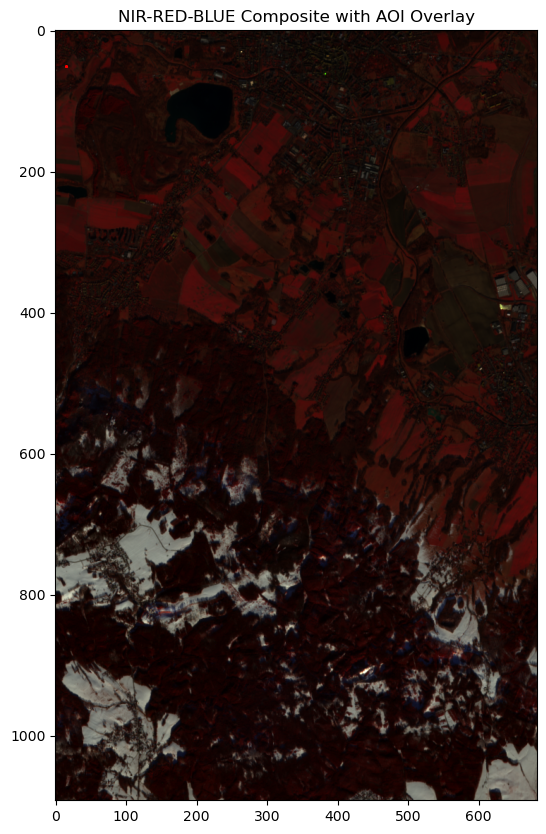

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Choose timestep of interest
first_time_step = stack.isel(time=0)

# Choose the needed bands
nir = first_time_step.sel(band='nir').values
red = first_time_step.sel(band='red').values
blue = first_time_step.sel(band='blue').values

# Had an issue with a warning so the following few lines may not be necessary but they got rid of it!
# Normalize the bands
def normalize(array):
    array = np.nan_to_num(array)
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

nir_norm = normalize(nir)
red_norm = normalize(red)
blue_norm = normalize(blue)

# Just a check and clip because of the issues mentioned above
nir_norm = np.clip(nir_norm, 0, 1)
red_norm = np.clip(red_norm, 0, 1)
blue_norm = np.clip(blue_norm, 0, 1)

# Stack them into an rgb image
rgb = np.dstack((nir_norm, red_norm, blue_norm))




#---Plotting---#
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb)
gdf.boundary.plot(ax=ax, color='red', linewidth=2)
plt.title('NIR-RED-BLUE Composite with AOI Overlay')
plt.show()


## 5. 

Calculate the bare soil index (BSI) for each timestep.

In [6]:
import xarray as xr

# Function that can be called later
def calculate_bsi(stack):
    '''calculates BSI for a given time step'''
    
    red = stack.sel(band='red')
    nir = stack.sel(band='nir')
    blue = stack.sel(band='blue')
    swir = stack.sel(band='swir16') # need this band now!

    # Pulled this from online (so hope it's right!)
    bsi = ((red + swir) - (nir + blue)) / ((red + swir) + (nir + blue))
    
    # Replace NaN and inf with nan (I do this as some errors came up)
    bsi = xr.where(xr.ufuncs.isfinite(bsi), bsi, np.nan)
    
    return bsi

# Calculate BSI for all times
bsi_stack = calculate_bsi(stack)


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_20681/4198538132.py:16: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  bsi = xr.where(xr.ufuncs.isfinite(bsi), bsi, np.nan)
/Users/jure/opt/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:3078: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


## 6. 

Create a binary mask of bare soil pixels for each timestep

In [7]:
# Define a threshold for bare soil
bsi_threshold = 0.26 # I really wasn't sure about the exact fraction (got this off the internet)

# Binary mask
bare_soil_mask = bsi_stack > bsi_threshold


## 7. 

Resample the soil mask stack to geographic coordinates (epsg:4326)

In [8]:
# just checking what the original crs is
import rioxarray

original_crs = stack.rio.crs
print("Original CRS:", original_crs)

Original CRS: EPSG:4326


In [9]:
from rasterio.enums import Resampling

# Converted to integer as had an error with rioxarray, not sure if I did something wrong before
bare_soil_mask_int = bare_soil_mask.astype(int)

# Write CRS information to the integer mask
bare_soil_mask_int_rio = bare_soil_mask_int.rio.write_crs("EPSG:4326")

# Dataset is already in EPSG:4326 so this is redundant
# But this is what the reprojection would look like
bare_soil_mask_int_resampled = bare_soil_mask_int_rio.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.nearest  # choosing the simplest way to resample
)


/Users/jure/opt/miniconda3/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


## 8. 

Aggregate bare soil percentage within the AOI for each timestep and plot the resulting time series.

In [10]:
# Calculate the bare soil percentage for each time step

# Sum up bare soil pixels for each time step
# divide by the total number of pixels in the AOI (multiply by 100 to get percentages)
bare_soil_percentage = bare_soil_mask.sum(dim=['x', 'y']) / (bare_soil_mask.sizes['x'] * bare_soil_mask.sizes['y']) * 100

/Users/jure/opt/miniconda3/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


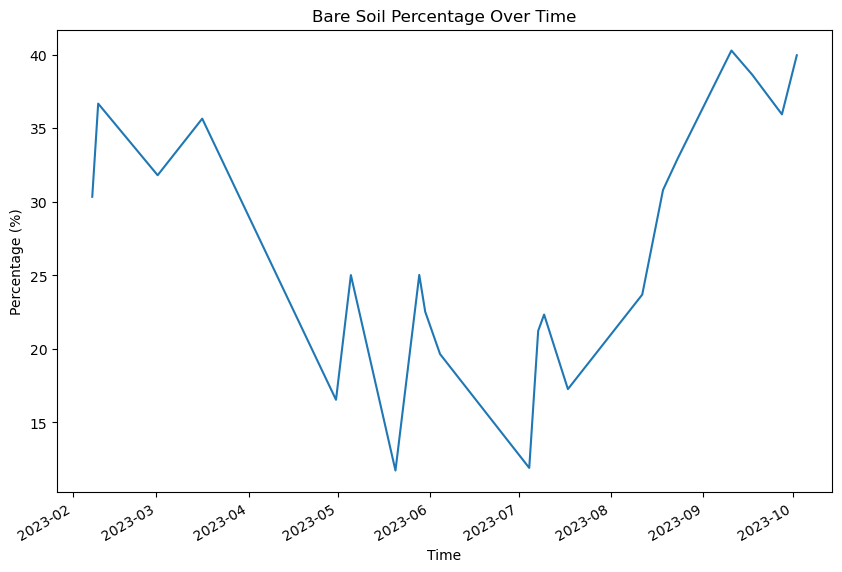

In [11]:
#---Plotting---#
plt.figure(figsize=(10, 6))
bare_soil_percentage.plot()
plt.title('Bare Soil Percentage Over Time')
plt.ylabel('Percentage (%)')
plt.xlabel('Time')
plt.show()